![Partners](../images/partners.png)

# ECMWF AIFS Forecast

This notebook retrieves operational weather forecasts from ECMWF's AI-based Integrated Forecast System (AIFS) for renewable energy applications.

## 1. Overview

This notebook demonstrates how to:
1. Connect to the ECMWF Open Data API
2. Download operational forecast data from the AI-based Integrated Forecast System (AIFS)
3. Process and visualize the forecast data
4. Save the data for further analysis

**Note:** No API key is required for ECMWF Open Data!

## 2. Import Required Libraries

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from ecmwf.opendata import Client

from plot import plot_variable

import warnings
warnings.filterwarnings("ignore")

## 3. Configure the ECMWF Client

We'll set up the client to access ECMWF's AIFS (Artificial Intelligence Forecasting System) operational forecasts. This model is operational since 25 February of 2025.

In [2]:
client = Client(
    "ecmwf", 
    model="aifs-single",  # ECMWF's AI-based Integrated Forecast System
    resol="0p25",         # 0.25 degree resolution (~28 km)
)


## 4. Define Configuration Parameters

Set up the region of interest, variables to download, and forecast steps.

In [3]:
var_dict = {
    'ssrd': 'ssrd',   # Surface solar radiation downwards
    # '100u': 'u100',   # 100m u-component of wind
    # '100v': 'v100',   # 100m v-component of wind
}

In [4]:
area_bbox = [18, 32, -5, 52]  # East Africa region

# Parameters to download
parameters = ['ssrd']

# Forecast steps (in hours, 6-hourly intervals up to 360 hours = 15 days)
steps = list(range(0, 60, 6))

# Output directory
oper_out_dir = Path("data/AIFS/output")
oper_out_dir.mkdir(parents=True, exist_ok=True)

## 5. Download Forecast Data

Now we'll download the operational forecast data for each parameter. This may take a few minutes depending on your connection.

In [7]:
for param in parameters:

    print(f"Downloading parameter: {param} ({var_dict.get(param, param)})")
    
    filename = 'tmp_oper.nc'

    # Retrieve operational forecast from latest run
    print("Retrieving data from ECMWF...")
    client.retrieve(
        date=0,           # Latest available date (0 = today)
        time=0,           # 00z run (can also use 6, 12, or 18 for other runs)
        step=steps,       # Forecast steps: 0, 6, 12, ..., 360 hours
        stream="oper",    # Operational high-resolution forecast
        type="fc",        # Forecast type
        levtype="sfc",    # Surface level
        param=param,      # Parameter to download
        target=filename   # Temporary file
    )
    print(f"Data downloaded to {filename}")



Retrieving data from ECMWF...


Data downloaded to tmp_oper.nc


In [8]:
# Open the downloaded NetCDF file
print("Loading dataset...")
ds = xr.open_dataset(filename, engine="cfgrib")
ds

Ignoring index file 'tmp_oper.nc.5b7b6.idx' older than GRIB file


Loading dataset...


<xarray.Dataset> Size: 42MB
Dimensions:     (step: 10, latitude: 721, longitude: 1440)
Coordinates:
  * step        (step) timedelta64[ns] 80B 0 days 00:00:00 ... 2 days 06:00:00
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    time        datetime64[ns] 8B ...
    surface     float64 8B ...
    valid_time  (step) datetime64[ns] 80B ...
Data variables:
    ssrd        (step, latitude, longitude) float32 42MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-18T12:49 GRIB to CDM+CF via cfgrib-0.9.1...

/opt/icpac-course/Capacity-Building-ICPAC-for-climate-services/.pixi/envs/default/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


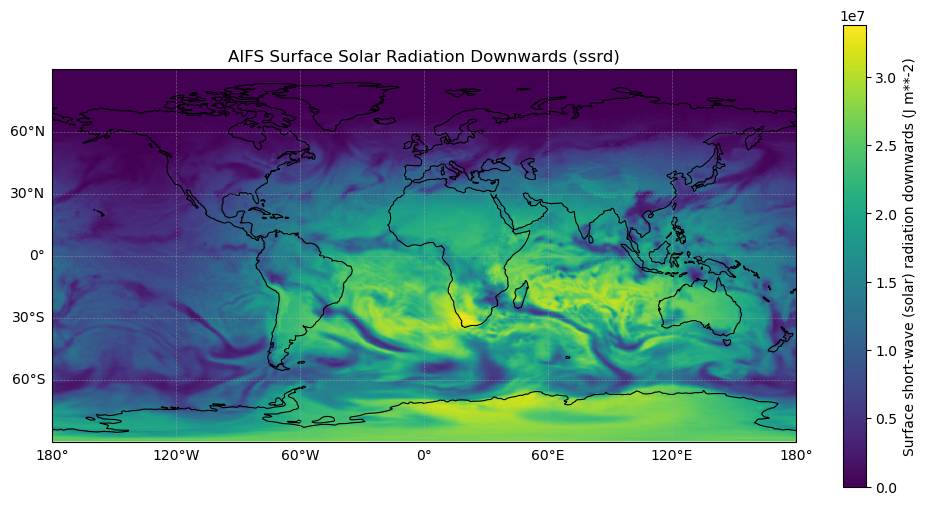

(<Figure size 1200x600 with 2 Axes>,
 <GeoAxes: title={'center': 'AIFS Surface Solar Radiation Downwards (ssrd)'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

In [9]:
# plot dataset

plot_variable(
    ds.sel(step="18:00:00"),
    var_name='ssrd',
    title='AIFS Surface Solar Radiation Downwards (ssrd)',
    )

In [10]:
# Convert step to timedelta and extract region
ds['step'] = pd.to_timedelta(ds.step.values)
ds = ds.sel(
    latitude=slice(area_bbox[0], area_bbox[2]), 
    longitude=slice(area_bbox[1], area_bbox[3])
)

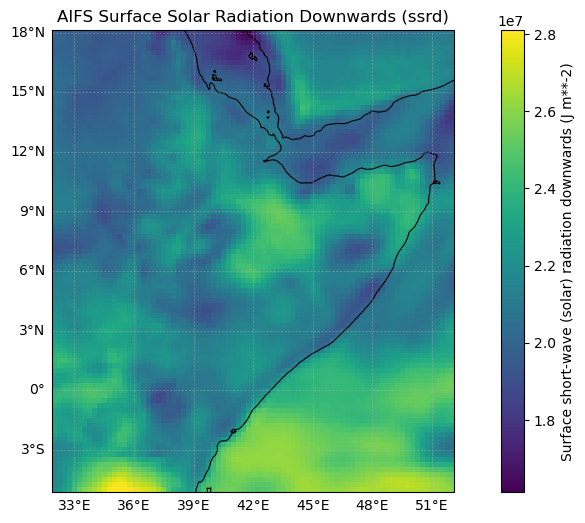

(<Figure size 1200x600 with 2 Axes>,
 <GeoAxes: title={'center': 'AIFS Surface Solar Radiation Downwards (ssrd)'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

In [11]:
plot_variable(
    ds.sel(step="18:00:00"),
    var_name='ssrd',
    title='AIFS Surface Solar Radiation Downwards (ssrd)',
    )

In [12]:
# Get forecast initialization time
forecast_datetime = ds.time.values
forecast_datetime_str = pd.to_datetime(forecast_datetime).strftime("%Y%m%d%H%M%S")

print(f"Forecast run time: {pd.to_datetime(forecast_datetime)}")
print(f"Dataset shape: {ds[var_dict[param]].shape}")
print(f"Time steps: {len(ds.step.values)}")

# Save the extracted dataset
out_fname = oper_out_dir / f'{forecast_datetime_str}-{steps[-1]}h_{param}.nc'
ds.to_netcdf(out_fname)
print(f"Saved to: {out_fname}")

# Clean up temporary file
Path(filename).unlink(missing_ok=True)

Forecast run time: 2025-11-18 00:00:00
Dataset shape: (10, 93, 81)
Time steps: 10
Saved to: data/AIFS/output/20251118000000-54h_ssrd.nc


## 6. Compare Solar Forecast with Climatology

Compare the forecast against climatological averages for the next 14 days.

In [13]:
# Select a location (e.g., Nairobi, Kenya: -1.28°N, 36.82°E)
location_name = "Nairobi, Kenya"
lat_point = -1.28
lon_point = 36.82


ds = xr.open_dataset(out_fname)

# Extract forecast at location
forecast_location = ds['ssrd'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
)

sh: 1: getfattr: not found


Text(0, 0.5, 'Surface Solar Radiation Downwards (J/m²)')

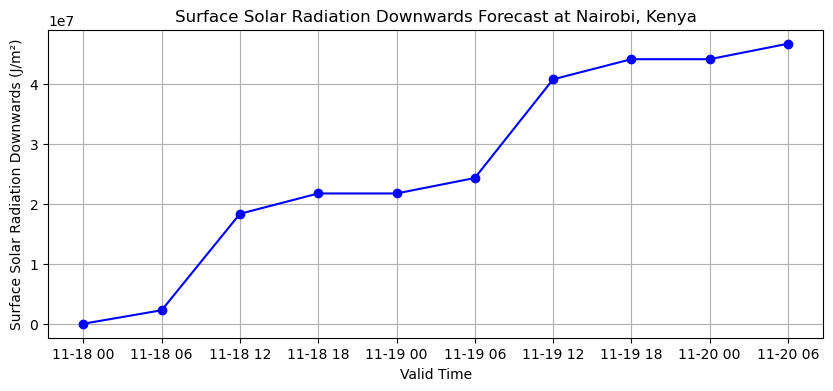

In [14]:
# The forecast is accumulated over time

plt.figure(figsize=(10, 4))
plt.plot(forecast_location.valid_time, forecast_location, marker='o', label='AIFS Forecast', color='blue')
plt.grid()
plt.title(f'Surface Solar Radiation Downwards Forecast at {location_name}')
plt.xlabel('Valid Time')
plt.ylabel('Surface Solar Radiation Downwards (J/m²)')

## 7. Resources

- [ECMWF Open Data Documentation](https://data.ecmwf.int/forecasts/)
- [ECMWF Open Data API](https://confluence.ecmwf.int/display/DAC/ECMWF+open+data%3A+real-time+forecasts+from+IFS+and+AIFS)
- [Available Parameters](https://codes.ecmwf.int/grib/param-db/)
- [AIFS Information](https://www.ecmwf.int/en/about/media-centre/news/2025/ecmwfs-ai-forecasts-become-operational)